# **01-03-2024** 
**`audio_sheet_retrieval/audio2sheet_align.py`**

In [1]:
from __future__ import print_function

import sys
import yaml
from tqdm import tqdm

from msmd.data_model.piece import Piece
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Enable autoreload
%load_ext autoreload

# Set autoreload mode to reload all modules every time before executing code
%autoreload 2

In [2]:
split_file = '/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/msmd/msmd/splits/all_split.yaml'
config_file = '/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/audio_sheet_retrieval/exp_configs/mutopia_no_aug.yaml'
DATA_ROOT_MSMD = '/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/msmd_aug_v1-1_no-audio'

with open(config_file, 'rb') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
def load_split(split_file):
    with open(split_file, 'rb') as f:
        split = yaml.load(f, Loader=yaml.FullLoader)
    return split

In [3]:
SHEET_CONTEXT = 200
SYSTEM_HEIGHT = 160
SPEC_CONTEXT = 42
SPEC_BINS = 92


NO_AUGMENT = dict()
NO_AUGMENT['system_translation'] = 0
NO_AUGMENT['sheet_scaling'] = [1.00, 1.00]
NO_AUGMENT['onset_translation'] = 0
NO_AUGMENT['spec_padding'] = 0
NO_AUGMENT['interpolate'] = -1
NO_AUGMENT['synths'] = ['ElectricPiano']
NO_AUGMENT['tempo_range'] = [1.00, 1.00]

# this will be overwritten with a config file
# (see audio_sheet_retrieval/exp_configs)
AUGMENT = dict()
for key in NO_AUGMENT.keys():
    AUGMENT[key] = NO_AUGMENT[key]
    
if not config_file:
    spec_context = SPEC_CONTEXT
    sheet_context = SHEET_CONTEXT
    staff_height = SYSTEM_HEIGHT
    augment = AUGMENT
    no_augment = NO_AUGMENT
    test_augment = NO_AUGMENT.copy()
else:
    with open(config_file, 'rb') as hdl:
        config = yaml.load(hdl, Loader=yaml.FullLoader)
    spec_context = config["SPEC_CONTEXT"]
    sheet_context = config["SHEET_CONTEXT"]
    staff_height = config["SYSTEM_HEIGHT"]
    augment = config["AUGMENT"]
    no_augment = NO_AUGMENT
    test_augment = NO_AUGMENT.copy()
    test_augment['synths'] = [config["TEST_SYNTH"]]
    test_augment['tempo_range'] = [config["TEST_TEMPO"], config["TEST_TEMPO"]]



In [4]:
from audio_sheet_retrieval.utils.data_pools import prepare_piece_data, AudioScoreRetrievalPool
piece_names = ['BachJS__BWV790__bwv790', 'BachJS__BWV952__fugue-c-major', 'Mendelssohn-BartholdyF__O19__5.Inquietude', 'SchumannR__O124__16-berceuse']
all_images = []
all_specs = []
all_o2c_maps = []
for ip in tqdm(range(len(piece_names)), ncols=70):
    piece_name = piece_names[ip]

    try:
        image, specs, o2c_maps = prepare_piece_data(DATA_ROOT_MSMD, piece_name,
                                                    aug_config=augment, require_audio=False)
    except:
        print("Problems with loading piece %s" % piece_name)
        print(sys.exc_info()[0])
        continue

    # keep stuff
    all_images.append(image)
    all_specs.append(specs)

100%|███████████████████████████████████| 4/4 [00:08<00:00,  2.16s/it]


In [5]:
example_piece = piece_names[3]
piece_image, piece_specs, piece_o2c_maps = prepare_piece_data(DATA_ROOT_MSMD, piece_name,
                                                    aug_config=augment, require_audio=False)
piece_image.shape, len(piece_specs[0]), (piece_o2c_maps[0].shape)

((200, 24921), 92, (781, 2))

In [6]:
# initialize data pool with piece
piece_pool = AudioScoreRetrievalPool([piece_image], [piece_specs], [piece_o2c_maps], data_augmentation=test_augment, shuffle=False)
spectrogram = piece_pool.specs[0][0]
sheet = piece_pool.images[0]

(200, 24921)


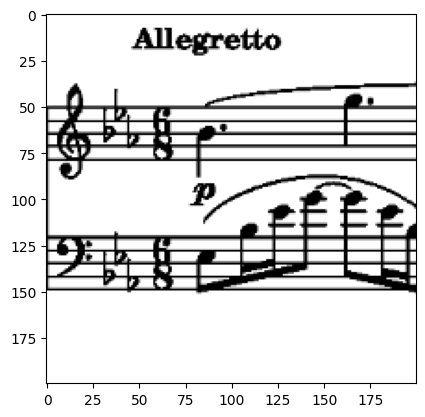

In [7]:
print(piece_pool.images[0].shape)
plt.imshow(piece_pool.images[0][:, :200], cmap='gray')
plt.show()

(92, 4767)


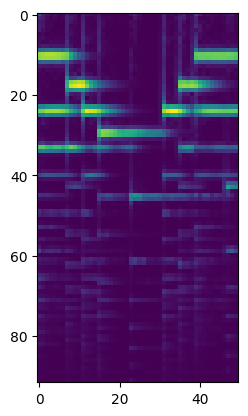

In [8]:
# plt.imshow((piece_pool.specs[0][0][:, :piece_pool.specs[0][0].shape[0]]))
print(piece_pool.specs[0][0].shape)
plt.imshow((piece_pool.specs[0][0][:, :50]))
plt.show()

In [9]:
coordinates = piece_pool.o2c_maps[0][0][:, 1]
onsets = piece_pool.o2c_maps[0][0][:, 0]
len(piece_pool.o2c_maps), len(piece_pool.o2c_maps[0]), (piece_pool.o2c_maps[0][0].shape), coordinates.shape, onsets.shape

(1, 1, (781, 2), (781,), (781,))

In [10]:
coordinates[:5], onsets[:5]

(array([ 87, 110, 127, 145, 166]), array([ 0,  8, 12, 16, 24]))

In [11]:
print(f'sheet image shape: {sheet.shape} | spectrogram shape:{spectrogram.shape}')
SPEC_CONTEXT = 42
INPUT_SHAPE_1 = [1, 160, 200]
INPUT_SHAPE_2 = [1, 92, SPEC_CONTEXT]

sheet_window_shape = INPUT_SHAPE_1[1:]
spectrogram_window_shape = INPUT_SHAPE_2[1:]


# prepare sample points
SHEET_STEP = 10
sheet_steps = sheet.shape[1] // SHEET_STEP
coordinate_0 = sheet_window_shape[1] //2
coordinate_1 = sheet.shape[1] - sheet_window_shape[1] //2
sheet_idxs = np.linspace(coordinate_0, coordinate_1, sheet_steps, dtype=int)


SPECTROGRAM_STEP = 2 
spectrogram_steps = spectrogram.shape[1] // SPECTROGRAM_STEP
onset_0 = spectrogram_window_shape[1] //2
onset_1 = spectrogram.shape[1] - spectrogram_window_shape[1] //2
spectrogram_idxs = np.linspace(onset_0, onset_1, spectrogram_steps, dtype=int)

sheet image shape: (200, 24921) | spectrogram shape:(92, 4767)


In [12]:
INPUT_SHAPE_1[1:], INPUT_SHAPE_2[1:],  sheet_window_shape[1],  sheet.shape[1]

([160, 200], [92, 42], 200, 24921)

In [13]:
sheet_idxs[:5], spectrogram_idxs[:5]

(array([100, 109, 119, 129, 139]), array([21, 22, 24, 26, 28]))

## Slice sheet images and spectrogram imagaes

In [14]:
sheet_slices = np.zeros((len(sheet_idxs), 1, sheet_window_shape[0], sheet_window_shape[1]), dtype=np.float32)
region_0 = sheet.shape[0]//2 - sheet_window_shape[0]//2
region_1 = region_0 + sheet_window_shape[0]
for j, x_coordinate in enumerate(sheet_idxs):
    sheet_slice = sheet[region_0:region_1, x_coordinate - coordinate_0 : x_coordinate + coordinate_0]   
    sheet_slices[j, 0] = sheet_slice

In [15]:
len(sheet_slices), sheet_slices[0].shape

(2492, (1, 160, 200))

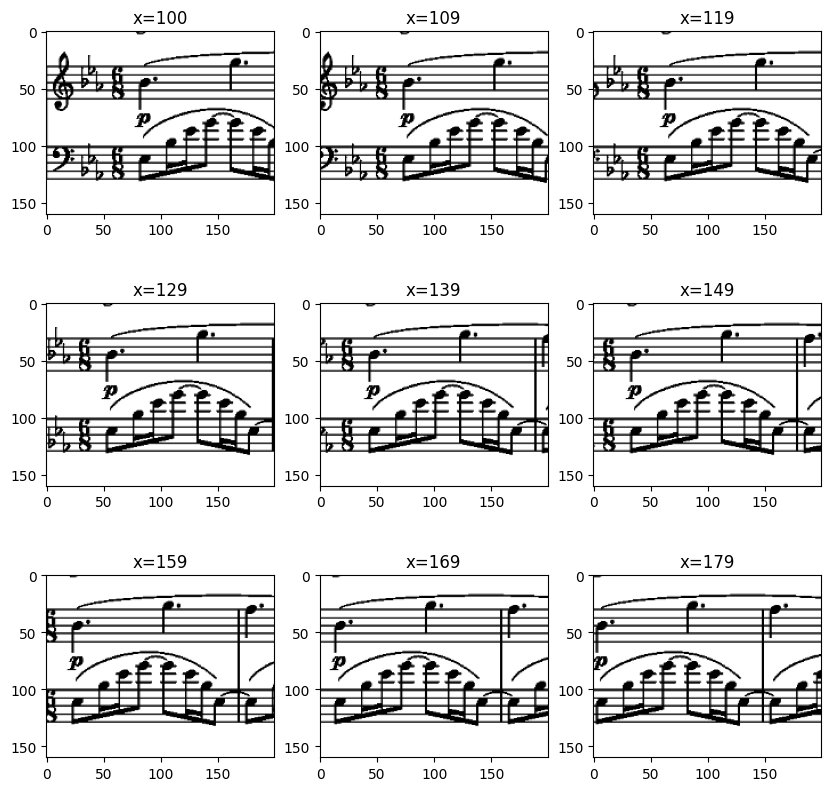

In [16]:
plt.figure('Sheet slices', figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sheet_slices[i, 0], cmap='gray')
    plt.title(f'x={sheet_idxs[i]}')

plt.show()

In [17]:
# Slide audio
spectrogram_slices = np.zeros((len(spectrogram_idxs), 1,  spectrogram_window_shape[0], spectrogram_window_shape[1]), dtype=np.float32)
for j, onset in enumerate(spectrogram_idxs):
    spectrogram_slice = spectrogram[:, onset - onset_0 : onset + onset_0]
    spectrogram_slices[j, 0] = spectrogram_slice

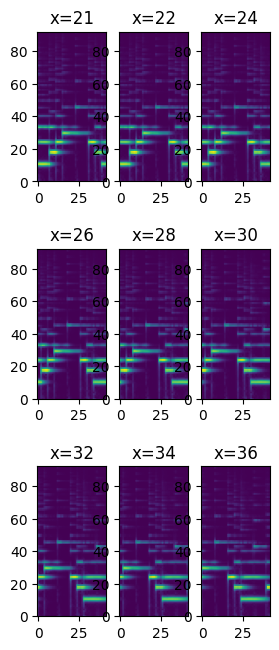

In [18]:
plt.figure('Spectrogram slices', figsize=(3,8))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(spectrogram_slices[i, 0], cmap='viridis')
    plt.title(f'x={spectrogram_idxs[i]}')
    # plt.xlim([0, 200])
    plt.ylim([0, spectrogram_slices[i, 0].shape[0]])
plt.show()

In [19]:
sheet_slices.shape, spectrogram_slices.shape

((2492, 1, 160, 200), (2383, 1, 92, 42))

In [20]:
DIM_LATENT = 32

In [21]:
# Shapes of final img_codes and specs_codes:

img_codes = np.zeros((sheet_slices.shape[0], DIM_LATENT), dtype=np.float32) 
specs_codes = np.zeros((spectrogram_slices.shape[0], DIM_LATENT), dtype=np.float32)
img_codes.shape, specs_codes.shape

((2492, 32), (2383, 32))

In [22]:
sheet_slices.shape

(2492, 1, 160, 200)

[]

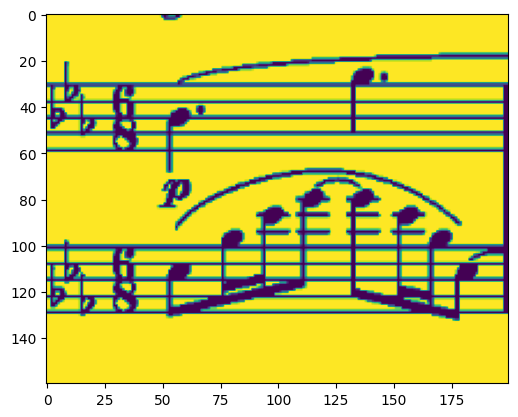

In [23]:
slice_test = sheet_slices[3:4]
plt.imshow(slice_test[0][0])
plt.plot()

In [24]:
for j in range(sheet_slices.shape[0]):
    images = sheet_slices[j:j+1]

## 🎐 Only taking the parts that are aligned 

In [25]:
# example_piece = piece_names[3]
# piece_image, piece_specs, piece_o2c_maps = prepare_piece_data(DATA_ROOT_MSMD, piece_name,
#                                                     aug_config=augment, require_audio=False)
piece_image.shape, len(piece_specs[0]), (piece_o2c_maps[0].shape)

((200, 24921), 92, (781, 2))

In [26]:
piece_o2c_maps[0][:5]

array([[  0,  87],
       [  8, 110],
       [ 12, 127],
       [ 16, 145],
       [ 24, 166]])

# 🍉 **05-03-2024** Attempting finding answers in:
- `audio_sheet_server.py`
- `AudioScoreRetrievalPool`
- `sheet_audio_server.py`
- `data_pools.py`
- `mutopia_data.py`

## 🦩 `audio_sheet_server.py`

In [27]:
for piece_index, piece in enumerate(piece_names):
        print(" (%03d / %03d) %s" % (piece_index + 1, len(piece_names), piece))
        piece_image, piece_specs, piece_o2c_maps = prepare_piece_data(DATA_ROOT_MSMD, piece, require_audio=False)
        piece_pool = AudioScoreRetrievalPool([piece_image], [piece_specs], [piece_o2c_maps], 
                                             data_augmentation=NO_AUGMENT, shuffle=False)

# print(piece_pool.shape, piece_image.shape, piece_specs.shape)
        # snippets = np.zeros((piece_pool.shape))

 (001 / 004) BachJS__BWV790__bwv790
 (002 / 004) BachJS__BWV952__fugue-c-major
 (003 / 004) Mendelssohn-BartholdyF__O19__5.Inquietude
 (004 / 004) SchumannR__O124__16-berceuse


In [28]:
piece_images, piece_specs, piece_o2c_maps = prepare_piece_data(DATA_ROOT_MSMD, piece_names[1], require_audio=False)
piece_pool = AudioScoreRetrievalPool([piece_images], [piece_specs], [piece_o2c_maps], data_augmentation=NO_AUGMENT, shuffle=False)

print(piece_pool.shape, (piece_image.shape), piece_specs[0].shape, len(piece_o2c_maps[0]))

[524] (200, 24921) (92, 2721) 528


I ONSET: 4 with 163 >> (0, 800)
    20, 180 -> 63, 263
I ONSET: 4 with 163 >> (0, 800)
    20, 180 -> 63, 263
I ONSET: 4 with 163 >> (0, 800)
    20, 180 -> 63, 263
<class 'audio_sheet_retrieval.utils.data_pools.AudioScoreRetrievalPool'> <class 'list'> 2
(160, 200) (1, 1, 92, 42)
I ONSET: 5 with 182 >> (0, 800)
    20, 180 -> 82, 282
I ONSET: 5 with 182 >> (0, 800)
    20, 180 -> 82, 282
I ONSET: 5 with 182 >> (0, 800)
    20, 180 -> 82, 282
<class 'audio_sheet_retrieval.utils.data_pools.AudioScoreRetrievalPool'> <class 'list'> 2
(160, 200) (1, 1, 92, 42)
I ONSET: 6 with 202 >> (0, 800)
    20, 180 -> 102, 302
I ONSET: 6 with 202 >> (0, 800)
    20, 180 -> 102, 302
I ONSET: 6 with 202 >> (0, 800)
    20, 180 -> 102, 302
<class 'audio_sheet_retrieval.utils.data_pools.AudioScoreRetrievalPool'> <class 'list'> 2
(160, 200) (1, 1, 92, 42)
I ONSET: 7 with 220 >> (0, 800)
    20, 180 -> 120, 320
I ONSET: 7 with 220 >> (0, 800)
    20, 180 -> 120, 320
I ONSET: 7 with 220 >> (0, 800)
    20, 18

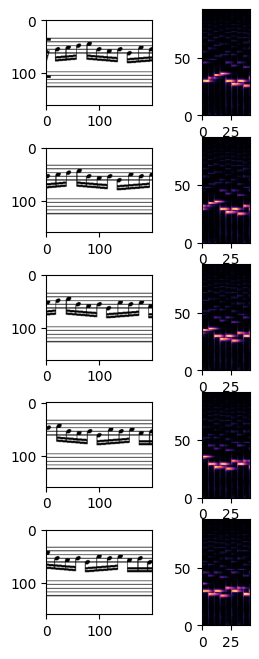

In [29]:
# for i in range(piece_pool.shape[0]):
SHEET_CONTEXT = 200
SYSTEM_HEIGHT = 160
SPEC_CONTEXT = 42
SPEC_BINS = 92

spec_shape = (SPEC_BINS, SPEC_CONTEXT)
sheet_shape = (SYSTEM_HEIGHT, SHEET_CONTEXT)
snippets = np.zeros((piece_pool.shape[0], 1, sheet_shape[0], sheet_shape[1]), dtype=np.uint8)
plt.figure('Spectrogram slices', figsize=(3,8))

plotting = 1
for i in range(5):
    plt.subplot(5, 2, plotting)
    plotting += 1

    snippet, audio_midi = piece_pool[i:i+1]
    print(type(piece_pool), type(piece_pool[i:i+1]), len(piece_pool[i:i+1]))
    plt.imshow(snippet[0][0], cmap='gray')
    plt.subplot(5, 2, plotting)
    plotting += 1
    plt.imshow(audio_midi[0][0], cmap='magma')
    plt.ylim([0, audio_midi[0][0].shape[0]])

    print(snippet[0][0].shape, audio_midi.shape)



# for i in range(9):
#     plt.imshow(spectrogram_slices[i, 0], cmap='viridis')
#     plt.title(f'x={spectrogram_idxs[i]}')
#     # plt.xlim([0, 200])
#     plt.ylim([0, spectrogram_slices[i, 0].shape[0]])
plt.show()

In [30]:
len(piece_pool[8]), (piece_pool[8][0][0].shape), (piece_pool[8][1][0].shape)

I ONSET: 12 with 320 >> (0, 800)
    20, 180 -> 220, 420
I ONSET: 12 with 320 >> (0, 800)
    20, 180 -> 220, 420
I ONSET: 12 with 320 >> (0, 800)
    20, 180 -> 220, 420


(2, (1, 160, 200), (1, 92, 42))

In [31]:
# max(piece_pool)

In [32]:
# for i in range(piece_pool.shape[0]):
SHEET_CONTEXT = 200
SYSTEM_HEIGHT = 160
SPEC_CONTEXT = 42
SPEC_BINS = 92

# spec_shape = (SPEC_BINS, SPEC_CONTEXT)
# sheet_shape = (SYSTEM_HEIGHT, SHEET_CONTEXT)
# snippets = np.zeros((piece_pool.shape[0], 1, sheet_shape[0], sheet_shape[1]), dtype=np.uint8)
# plt.figure('Spectrogram slices', figsize=(3,8))

# plotting = 1
# for i in range(2):
#     print(f'indeces: {i} {i+1} piece_pool {len(piece_pool[i:i+1])}')
#     plt.subplot(2, 2, plotting)
#     plotting += 1
#     align_im_index, align_audio_index = piece_pool.o2c_maps[0][0][i]
#     align_im, _ = piece_pool[align_im_index]
#     _, align_audio = piece_pool[align_audio_index]
#     print(f'align: {align_im} {align_audio}')
#     snippet, audio_midi = piece_pool[i:i+1]
#     snippet_test = piece_pool.images[0][piece_pool.o2c_maps[0][0][i]]
#     # audio_test = 
#     print(len(piece_pool.o2c_maps[0][0][i]), (piece_pool.images[0].shape), len(piece_pool.specs[0]))
#     plt.imshow(align_im[0][0], cmap='gray')
#     plt.subplot(2, 2, plotting)
#     plotting += 1
#     plt.imshow(align_audio[0][0], cmap='magma')
#     plt.ylim([0, audio_midi[0][0].shape[0]])

#     print(snippet[0][0].shape, audio_midi.shape)



# # for i in range(9):
# #     plt.imshow(spectrogram_slices[i, 0], cmap='viridis')
# #     plt.title(f'x={spectrogram_idxs[i]}')
# #     # plt.xlim([0, 200])
# #     plt.ylim([0, spectrogram_slices[i, 0].shape[0]])
# plt.show()

## 🐩 `AudioScoreRetrievalPool`

In [33]:
piece_pool.prepare_train_entities()

In [34]:
piece_pool.train_entities[:5], piece_pool.train_entities[-5:]

(array([[0, 0, 4],
        [0, 0, 5],
        [0, 0, 6],
        [0, 0, 7],
        [0, 0, 8]]),
 array([[  0,   0, 523],
        [  0,   0, 524],
        [  0,   0, 525],
        [  0,   0, 526],
        [  0,   0, 527]]))

In [35]:
len(piece_pool.o2c_maps), len(piece_pool.o2c_maps[0]),len(piece_pool.o2c_maps[0][0]), piece_pool.o2c_maps[0][0].shape

(1, 1, 528, (528, 2))

In [36]:

piece_pool.o2c_maps[0][0][3], piece_pool.o2c_maps[0][0][3, 0], piece_pool.o2c_maps[0][0][3, 1]

(array([ 20, 144]), 20, 144)

### ☄️ Visualise the elements that are not within the range

In [37]:

for i_sheet, sheet in enumerate(piece_pool.images):
    for i_spec, spec in enumerate(piece_pool.specs[i_sheet]):
        print(f'sheets: {i_sheet}, spectrograms: {i_spec}, aligned elements: {len(piece_pool.o2c_maps[i_sheet][i_spec])}')
        for i_onset in range(len(piece_pool.o2c_maps[i_sheet][i_spec])):
            onset = piece_pool.o2c_maps[i_sheet][i_spec][i_onset, 0]
            o_start = onset = piece_pool.spec_context //2
            o_stop = o_start + piece_pool.spec_context

            coord = piece_pool.o2c_maps[i_sheet][i_spec][i_onset, 1]
            c_start = coord = piece_pool.sheet_context //2
            c_stop = c_start + piece_pool.sheet_context

            if not (o_start>=0 and o_stop<spec.shape[1] and c_start >=0 and c_stop < sheet.shape[1]):
                print(f'nope')



sheets: 0, spectrograms: 0, aligned elements: 528


## 🎂 BINGO!

0 0
5 9 51 82 209
6 14 56 102 214
7 19 61 120 219
8 24 66 142 224
9 29 71 162 229


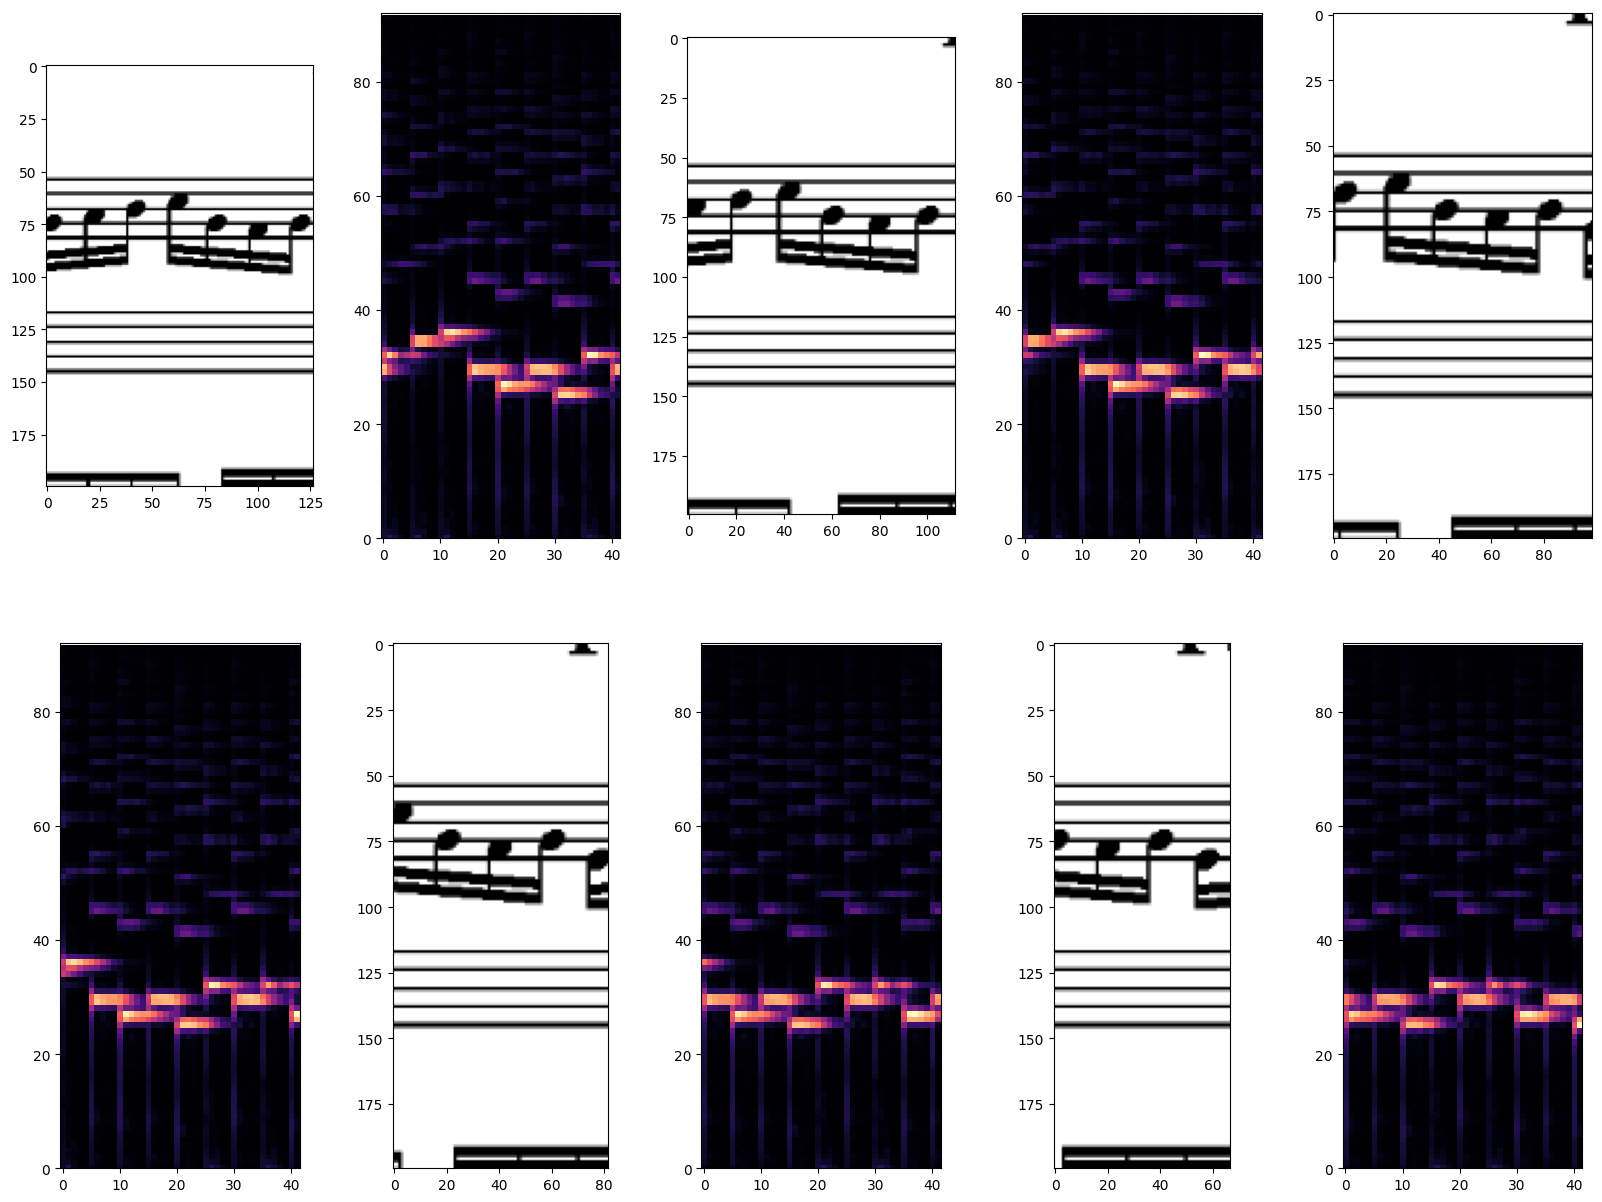

In [38]:
plt.figure('Spectrogram slices', figsize=(20,15))
plotting = 1
for i_sheet, sheet in enumerate(piece_pool.images):

    # iterate spectrograms
    for i_spec, spec in enumerate(piece_pool.specs[i_sheet]):
        print(i_sheet, i_spec)
        # iterate onsets in sheet
        for i_onset in range(5, 10):
        # for i_onset in range(len(piece_pool.o2c_maps[i_sheet][i_spec])):

            onset = piece_pool.o2c_maps[i_sheet][i_spec][i_onset, 0]
            o_start = onset - piece_pool.spec_context // 2
            o_stop = o_start + piece_pool.spec_context

            coord = piece_pool.o2c_maps[i_sheet][i_spec][i_onset, 1]
            c_start = coord - piece_pool.sheet_context // 2
            c_stop = o_start + piece_pool.sheet_context
            if o_start >= 0 and o_stop < spec.shape[1]\
                            and c_start >= 0 and c_stop < sheet.shape[1]:
                
                plt.subplot(2, 5, plotting)
                plotting+=1
                plt.imshow(sheet[:, c_start:c_stop], cmap='gray')
                # plt.ylim([0, audio_midi[0][0].shape[0]])
                plt.subplot(2, 5, plotting)
                plt.imshow(spec[:, o_start:o_stop], cmap='magma')
                plt.ylim([0, audio_midi[0][0].shape[0]])
                plotting += 1
                print(i_onset, o_start, o_stop, c_start, c_stop)
            # print(i_onset)

In [39]:
c_start, c_stop
sheet[:,c_start:c_stop].shape
# plt.imshow(sheet[c_start:c_stop, :])


(200, 67)

In [40]:
# for i_sheet, sheet in enumerate(self.images):

#             # iterate spectrograms
#             for i_spec, spec in enumerate(self.specs[i_sheet]):

#                 # iterate onsets in sheet
#                 for i_onset in range(len(self.o2c_maps[i_sheet][i_spec])):

#                     onset = self.o2c_maps[i_sheet][i_spec][i_onset, 0]
#                     o_start = onset - self.spec_context // 2
#                     o_stop = o_start + self.spec_context

#                     coord = self.o2c_maps[i_sheet][i_spec][i_onset, 1]
#                     c_start = coord - self.sheet_context // 2
#                     c_stop = o_start + self.sheet_context

In [41]:
sheet_batch , spec_batch = piece_pool.__getitem__(0)
(sheet_batch[0][0].shape, spec_batch[0][0].shape)

I ONSET: 4 with 163 >> (0, 800)
    20, 180 -> 63, 263


((160, 200), (92, 42))

I ONSET: 4 with 163 >> (0, 800)
    20, 180 -> 63, 263
(160, 200) (92, 42)
I ONSET: 5 with 182 >> (0, 800)
    20, 180 -> 82, 282
(160, 200) (92, 42)
I ONSET: 6 with 202 >> (0, 800)
    20, 180 -> 102, 302
(160, 200) (92, 42)
I ONSET: 7 with 220 >> (0, 800)
    20, 180 -> 120, 320
(160, 200) (92, 42)
I ONSET: 8 with 242 >> (0, 800)
    20, 180 -> 142, 342
(160, 200) (92, 42)
I ONSET: 9 with 262 >> (0, 800)
    20, 180 -> 162, 362
(160, 200) (92, 42)
I ONSET: 10 with 282 >> (0, 800)
    20, 180 -> 182, 382
(160, 200) (92, 42)
I ONSET: 11 with 300 >> (0, 800)
    20, 180 -> 200, 400
(160, 200) (92, 42)
I ONSET: 12 with 320 >> (0, 800)
    20, 180 -> 220, 420
(160, 200) (92, 42)
I ONSET: 13 with 338 >> (0, 800)
    20, 180 -> 238, 438
(160, 200) (92, 42)


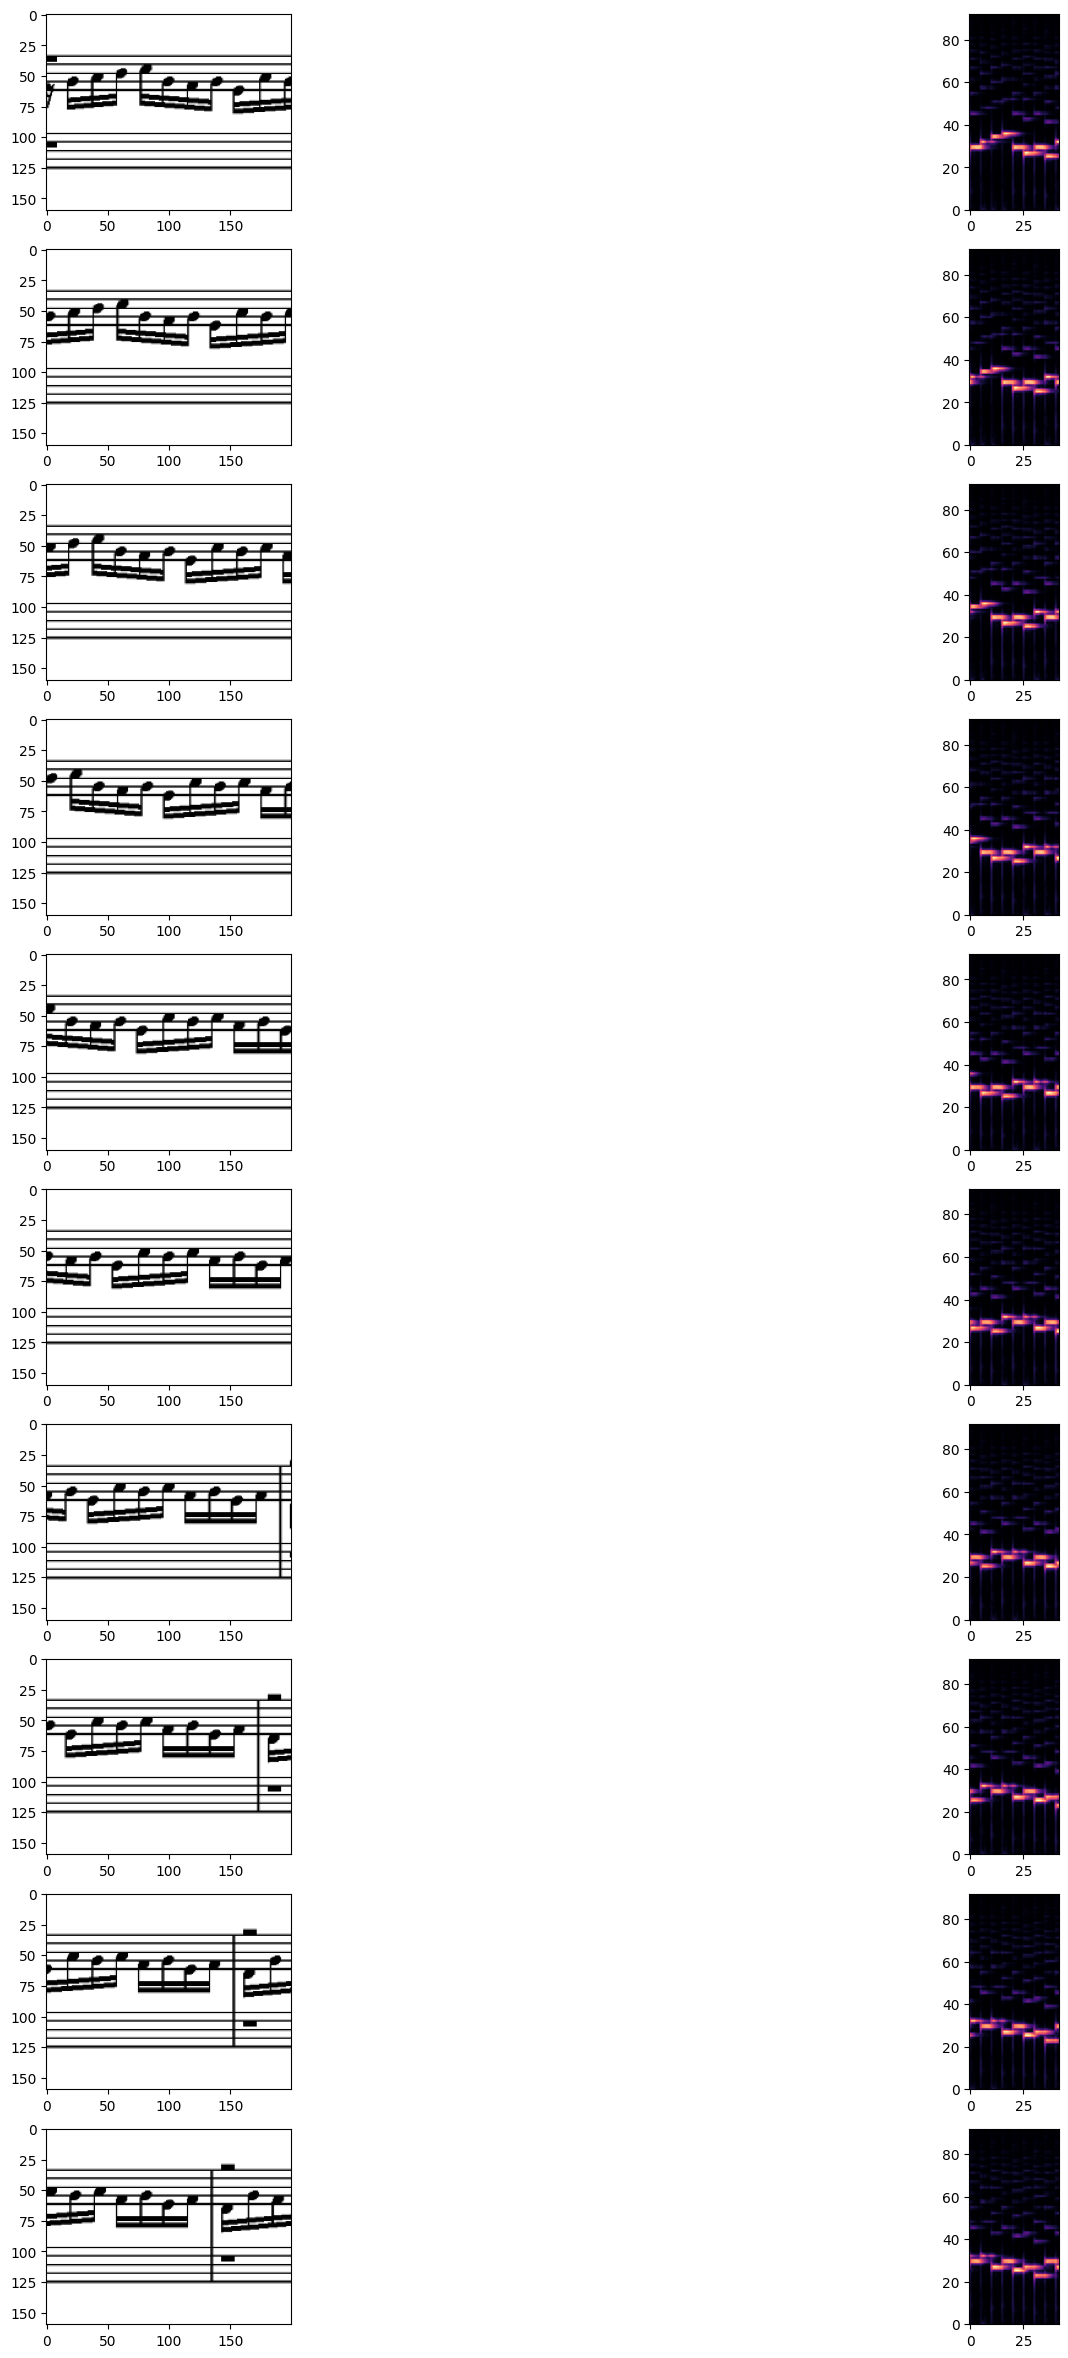

In [42]:
plt.figure('Spectrogram slices & Sheet snippets', figsize=(20,30))

plotting = 1
for i in range(10):
    # print(i)
    sheet_batch , spec_batch = piece_pool.__getitem__(i)
    print(sheet_batch[0][0].shape, spec_batch[0][0].shape)

    plt.subplot(10, 2, plotting)
    plt.imshow(sheet_batch[0][0], cmap='gray')
    plotting +=1
    
    plt.subplot(10, 2, plotting)
    plt.ylim([0, audio_midi[0][0].shape[0]])
    plt.imshow(spec_batch[0][0], cmap='magma')
    plotting +=1

plt.show()

In [43]:
piece_pool.train_entities[:, 2]

array([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 18

# 🎪 07-03-2024 

## 🧯 `__getitem__()`

In [44]:
key = 10
if key.__class__ == int:
    key = slice(key, key + 1)
    batch_entities = piece_pool.train_entities[key]

    # collect train entities
    sheet_batch = np.zeros((len(batch_entities), 1, piece_pool.sheet_dim[0], piece_pool.sheet_context), dtype=np.float32)
    spec_batch = np.zeros((len(batch_entities), 1, piece_pool.spec_dim[0], piece_pool.spec_context), dtype=np.float32)
    for i_entity, (i_sheet, i_spec, i_onset) in enumerate(batch_entities):
        print(i_entity)
        # get sliding window train item
        snippet = piece_pool.prepare_train_image(i_sheet, i_spec, i_onset)

        # get spectrogram excerpt (target note in center)
        excerpt = piece_pool.prepare_train_audio(i_sheet, i_spec, i_onset)

        # collect batch data
        sheet_batch[i_entity, 0, :, :] = snippet
        spec_batch[i_entity, 0, :, :] = excerpt

0
I ONSET: 14 with 358 >> (0, 800)
    20, 180 -> 258, 458


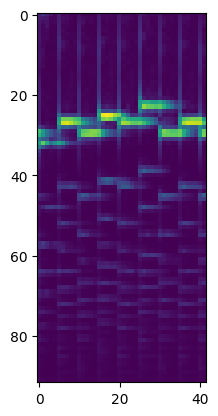

In [45]:
plt.imshow(spec_batch[0][0])

### 🦊 BINGO 2 👘 `prepare_train_image()`

In [46]:
sheet_batch[0][0].shape

(160, 200)

I ONSET: 10 with 282 >> (0, 800)
    20, 180 -> 182, 382
282 (160, 200)
I ONSET: 11 with 300 >> (0, 800)
    20, 180 -> 200, 400
300 (160, 200)
I ONSET: 12 with 320 >> (0, 800)
    20, 180 -> 220, 420
320 (160, 200)
I ONSET: 13 with 338 >> (0, 800)
    20, 180 -> 238, 438
338 (160, 200)
I ONSET: 14 with 358 >> (0, 800)
    20, 180 -> 258, 458
358 (160, 200)
I ONSET: 15 with 386 >> (0, 800)
    20, 180 -> 286, 486
386 (160, 200)


I ONSET: 16 with 407 >> (7, 807)
    20, 180 -> 307, 507
407 (160, 200)
I ONSET: 17 with 427 >> (27, 827)
    20, 180 -> 327, 527
427 (160, 200)
I ONSET: 18 with 447 >> (47, 847)
    20, 180 -> 347, 547
447 (160, 200)
I ONSET: 19 with 465 >> (65, 865)
    20, 180 -> 365, 565
465 (160, 200)
I ONSET: 20 with 485 >> (85, 885)
    20, 180 -> 385, 585
485 (160, 200)
I ONSET: 21 with 503 >> (103, 903)
    20, 180 -> 403, 603
503 (160, 200)


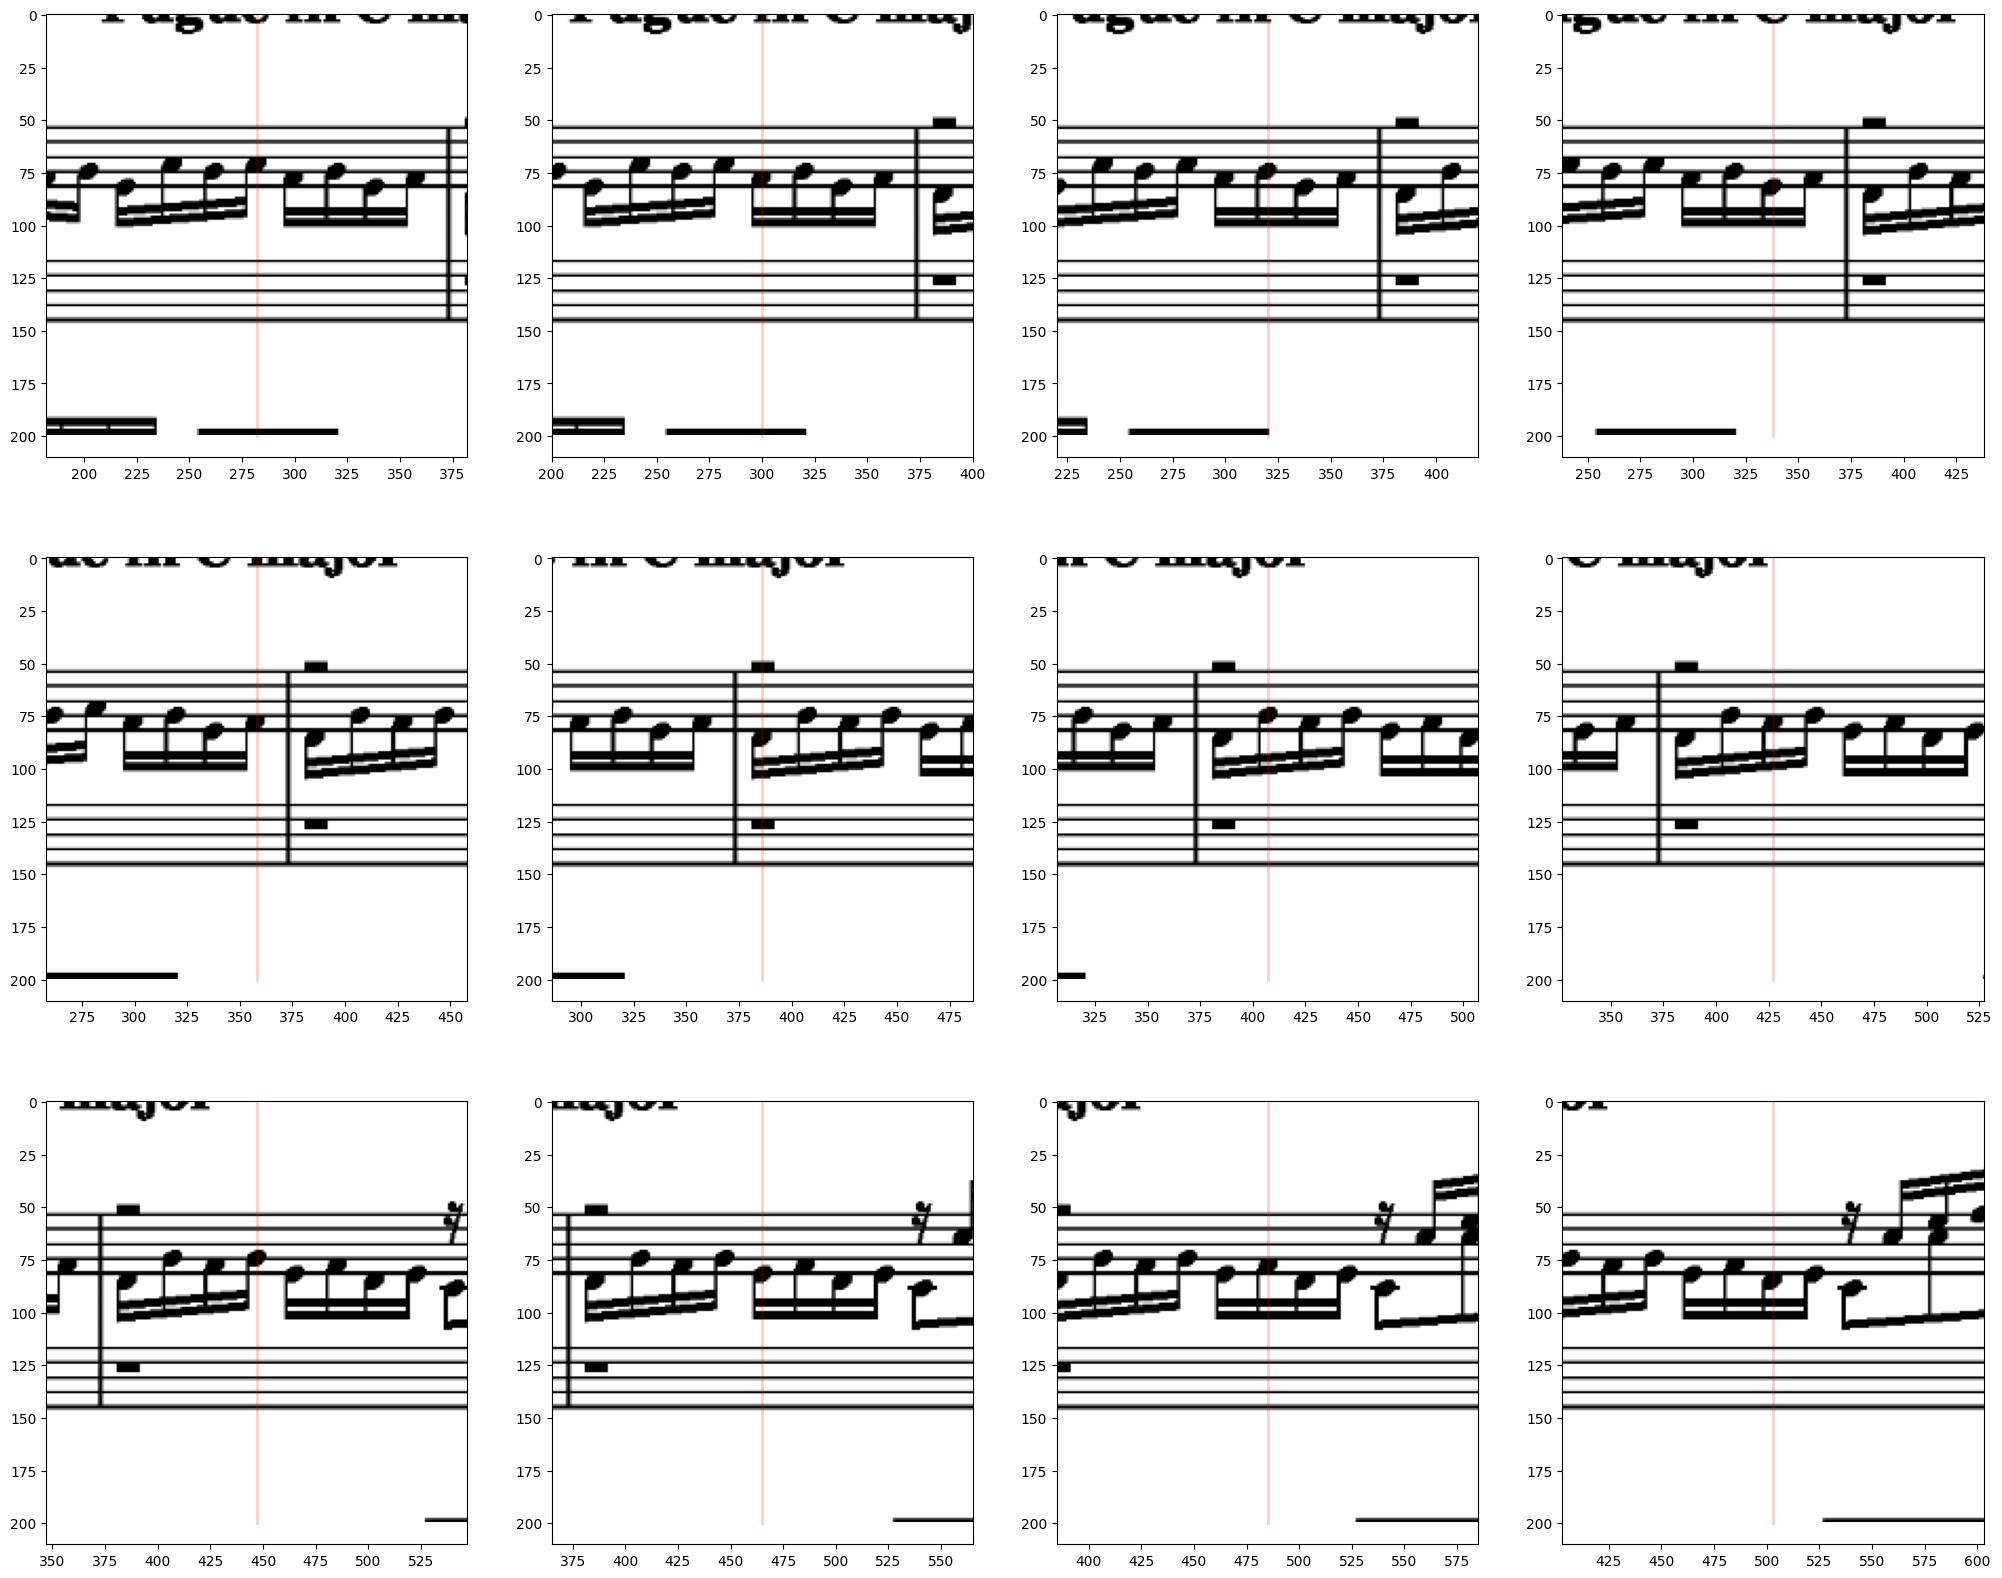

In [47]:
plt.figure('Spectrogram slices & Sheet snippets', figsize=(25,20))
mappings = piece_pool.o2c_maps[0][0]
plotting = 1
for i in range(10, 22):
    mapping = mappings[i]    
    coord = mapping[1]

    c_start = coord - piece_pool.sheet_context // 2
    c_start = max(0, c_start)
    c_stop = c_start + piece_pool.sheet_context

    train_image = piece_pool.prepare_train_image(0, 0, i)
    print(piece_pool.o2c_maps[0][0][i][1], train_image.shape)
    plt.subplot(3, 4, plotting)
    # plt.imshow(train_image, cmap='gray')
    plt.imshow(piece_pool.images[0], cmap='gray')

    # plt.title(f"Note: {}")
    plt.plot([coord, coord], [0, piece_pool.images[0].shape[0]], 'r-', alpha=.2, linewidth=2)

    plt.xlim((c_start, c_stop))

    plotting +=1
    

plt.show()



In [48]:
piece_pool.sheet_context

200

In [49]:
len(piece_pool.o2c_maps[0][0]), len(piece_pool.train_entities)

(528, 524)

In [50]:
piece_pool.o2c_maps[0][0][0][1]

85

In [51]:
c_start, c_stop

(403, 603)

403 603


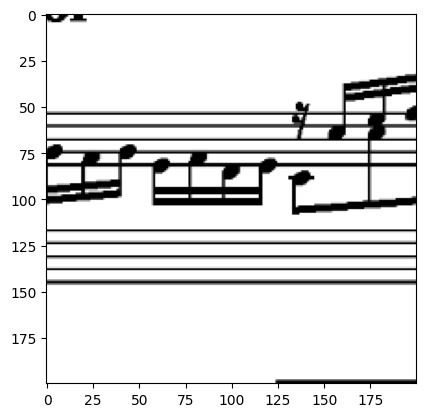

In [52]:

# plt.imshow(piece_pool.images[0][:, 0:1000], cmap='gray')
print(c_start, c_stop)
plt.imshow(piece_pool.images[0][:,c_start:c_stop], cmap='gray')



Mapping: [ 355 1650]
Coordinates: 1550, 1650, 1750
Onsets: 334, 355, 376
I ONSET: 4 with 163 >> (0, 800)
    20, 180 -> 63, 263
      (200, 200) (1, 0, 160, 200)
Mapping: [ 360 1670]
Coordinates: 1570, 1670, 1770
Onsets: 339, 360, 381
I ONSET: 4 with 163 >> (0, 800)
    20, 180 -> 63, 263
      (200, 200) (1, 0, 160, 200)
Mapping: [ 365 1693]
Coordinates: 1593, 1693, 1793
Onsets: 344, 365, 386
I ONSET: 4 with 163 >> (0, 800)
    20, 180 -> 63, 263
      (200, 200) (1, 0, 160, 200)
Mapping: [ 370 1714]
Coordinates: 1614, 1714, 1814
Onsets: 349, 370, 391
I ONSET: 4 with 163 >> (0, 800)
    20, 180 -> 63, 263
      (200, 200) (1, 0, 160, 200)


Mapping: [ 375 1736]
Coordinates: 1636, 1736, 1836
Onsets: 354, 375, 396
I ONSET: 4 with 163 >> (0, 800)
    20, 180 -> 63, 263
      (200, 200) (1, 0, 160, 200)


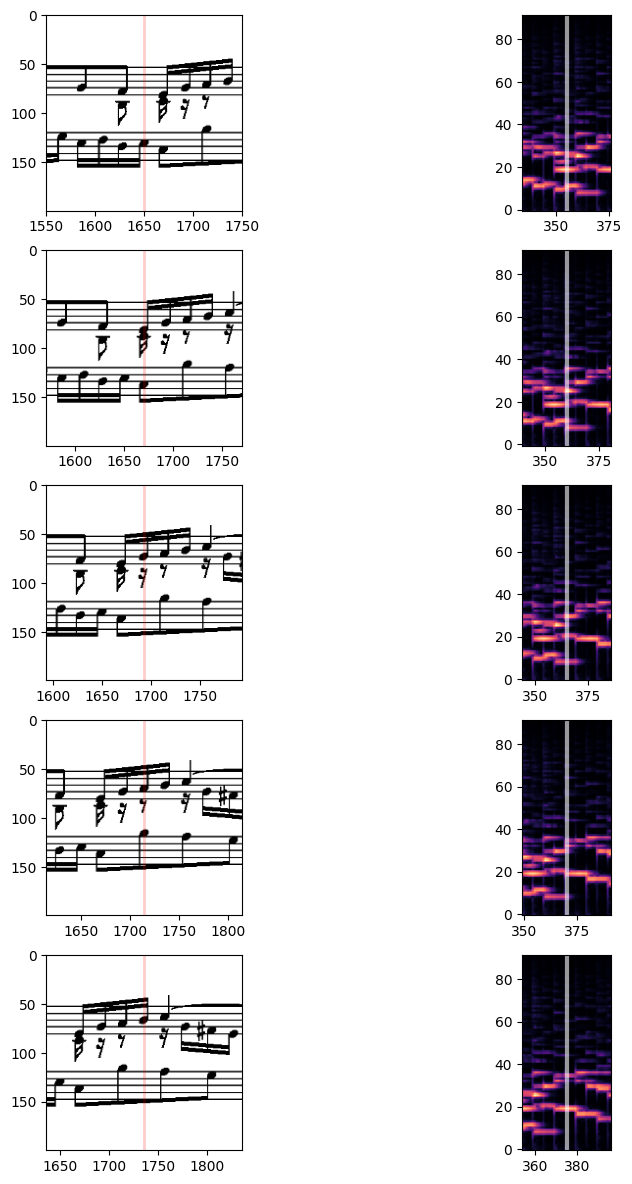

In [53]:
fig = plt.figure('Spectrogram slices & Sheet snippets', figsize=(10,30))
mappings = piece_pool.o2c_maps[0][0]
plotting = 1
for i in range(70, 75):
    # print(i)
    mapping = mappings[i]    
    print(f'Mapping: {mapping}')

    coord = mapping[1]
    c_start = coord - piece_pool.sheet_context // 2
    c_start = max(0, c_start)
    c_stop = c_start + piece_pool.sheet_context
    # c_stop = min(piece_pool.images[0].shape[1], c_stop)
    print(f'Coordinates: {c_start}, {coord}, {c_stop}')

    onset = mapping[0]
    o_start = onset - piece_pool.spec_context // 2
    o_stop = o_start + piece_pool.spec_context    
    o_start = max(0, o_start)
    o_stop = min(piece_pool.specs[0][0].shape[1], o_stop)

    print(f'Onsets: {o_start}, {onset}, {o_stop}')

    # sheet_batch , spec_batch = piece_pool.__getitem__(i)
    # print((piece_pool.images[0].shape), (piece_pool.specs[0][0].shape))
    # print(f'    ({c_start, c_stop}), ({o_start}, {o_stop})')
    print('     ',piece_pool.images[0][:,c_start:c_stop].shape, piece_pool[0][0][:, o_start:o_stop].shape)

    plt.subplot(10, 2, plotting)
    plt.plot([coord, coord], [0, piece_pool.images[0].shape[0]], 'r-', alpha=.2, linewidth=2)
    # plt.plot([c_start, c_start], [0, piece_pool.images[0].shape[0]], 'y-', alpha=.2, linewidth=2)
    # plt.plot([c_stop, c_stop], [0, piece_pool.images[0].shape[0]], 'o-', alpha=.2, linewidth=2)
    # plt.imshow(piece_pool.images[0][:,c_start:c_stop], cmap='gray')
    plt.imshow(piece_pool.images[0], cmap='gray')
    plt.xlim((c_start, c_stop))
    # plt.savefig(f'Testing how the alignments snippets {o_start} are shown.png', bbox_inches='tight')
    # plt.close(fig)

    plotting +=1
    
    plt.subplot(10, 2, plotting)
    plt.plot([onset, onset], [0, piece_pool.specs[0][0].shape[0]], 'w-', alpha=.6, linewidth=3)
    # plt.imshow(piece_pool.specs[0][0][:, o_start:o_stop], cmap='magma', origin='lower')
    plt.imshow(piece_pool.specs[0][0], cmap='magma', origin='lower')
    plt.xlim((o_start, o_stop))
    # plt.savefig(f'Testing how the alignments snippets {c_start} are shown.png', bbox_inches='tight')
    # plt.close(fig)

    plotting +=1
plt.show()

#### 🍄 `prepare_train_images()`

I ONSET: 0 with 85 >> (0, 800)
    20, 180 -> 0, 200
85 (160, 200)
I ONSET: 1 with 105 >> (0, 800)
    20, 180 -> 5, 205
105 (160, 200)
I ONSET: 2 with 125 >> (0, 800)
    20, 180 -> 25, 225
125 (160, 200)
I ONSET: 3 with 144 >> (0, 800)
    20, 180 -> 44, 244
144 (160, 200)


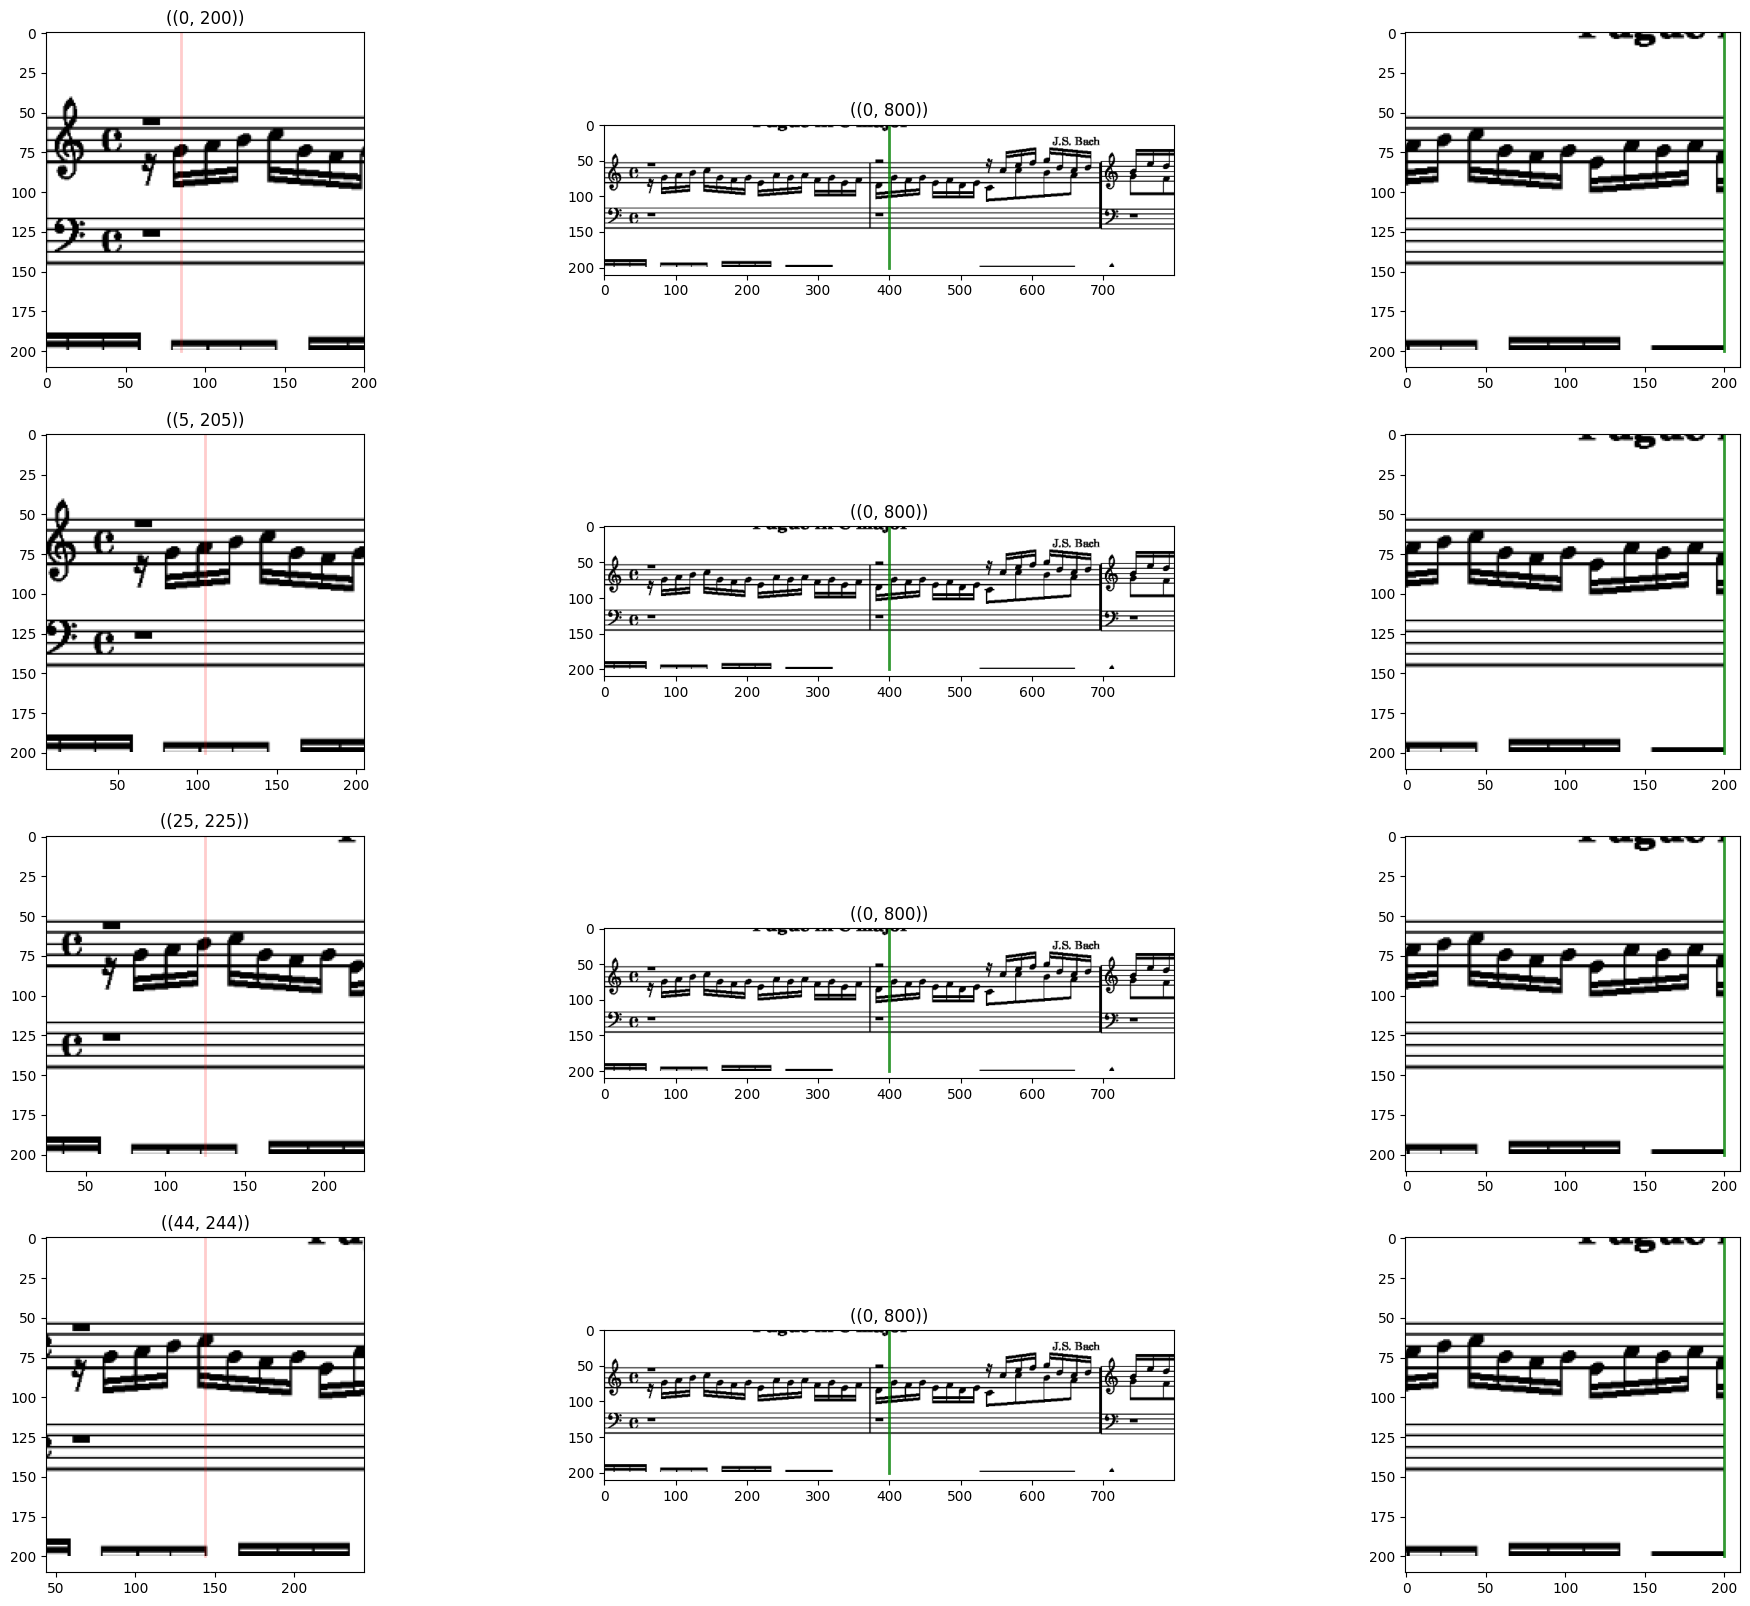

In [54]:
plt.figure('Spectrogram slices & Sheet snippets', figsize=(25,20))
mappings = piece_pool.o2c_maps[0][0]
plotting = 1
for i in range(0, 4):
    mapping = mappings[i]    
    coord = mapping[1]

    c0 = max(0, coord - 2*piece_pool.sheet_context)
    c1 = min(c0 + 4*piece_pool.sheet_context, piece_pool.images[0].shape[1])
    sheet = piece_pool.images[0][:, c0:c1]


    c_start = coord - piece_pool.sheet_context // 2
    c_start = max(0, c_start)
    c_stop = c_start + piece_pool.sheet_context

    train_image = piece_pool.prepare_train_image(0, 0, i)
    print(piece_pool.o2c_maps[0][0][i][1], train_image.shape)
    plt.subplot(4, 3, plotting)
    # plt.imshow(train_image, cmap='gray')
    plt.imshow(piece_pool.images[0], cmap='gray')
    plt.title(f'({c_start, c_stop})')

    # plt.title(f"Note: {}")
    plt.plot([coord, coord], [0, piece_pool.images[0].shape[0]], 'r-', alpha=.2, linewidth=2)

    plt.xlim((c_start, c_stop))

    plotting +=1

    plt.subplot(4, 3, plotting)
    plt.imshow(sheet, cmap='gray')
    # target coordinate
    x = sheet.shape[1]//2
    plt.plot([x, x], [0, sheet.shape[0]], 'g-', alpha=.8, linewidth=2)

    plt.title(f'({c0, c1})')
    plotting +=1

    # Line 150 
    # compute sliding window coordinates
    plt.subplot(4, 3, plotting)
    x0 = np.max([piece_pool.sheet_context//2], 0)
    x1 = x0 + piece_pool.sheet_context
    sheet_snippet = sheet[:, x0:x1]
    plt.imshow(sheet_snippet, cmap='gray')
    plt.plot([x0 + (piece_pool.sheet_context//2), x0 + (piece_pool.sheet_context//2)], [0, sheet.shape[0]], 'g-', alpha=.8, linewidth=2)

    plotting +=1

    

plt.show()



#### 🐛 Testing the content of main function of `data_pools.py`

In [55]:

def load_audio_score_retrieval():
    """
    Load alignment data
    """

    # Give piece dir
    # collection_dir = '/home/matthias/cp/data/msmd'

    piece_names = ['BachCPE__cpe-bach-rondo__cpe-bach-rondo', 'BachJS__BWV259__bwv-259']

    all_piece_images = []
    all_piece_specs = []
    all_piece_o2c_maps = []
    for piece_name in piece_names:

        piece_image, piece_specs, piece_o2c_maps = prepare_piece_data(DATA_ROOT_MSMD, piece_name, require_audio=False)

        # keep stuff
        all_piece_images.append(piece_image)
        all_piece_specs.append(piece_specs)
        all_piece_o2c_maps.append(piece_o2c_maps)

    return AudioScoreRetrievalPool(all_piece_images, all_piece_specs, all_piece_o2c_maps,
                                   data_augmentation=AUGMENT)

I ONSET: 475 with 9242 >> (8842, 9642)
    20, 180 -> 599, 799


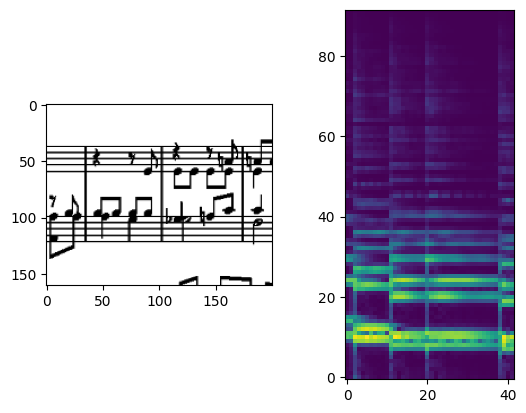

I ONSET: 146 with 2739 >> (2339, 3139)
    20, 180 -> 599, 799


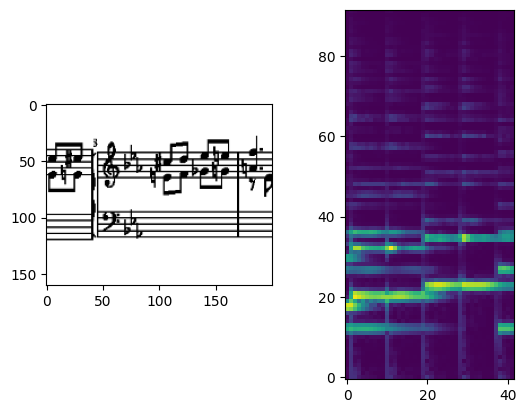

In [56]:
# from audio_sheet_retrieval.utils.data_pools import load_audio_score_retrieval

pool = load_audio_score_retrieval()

for i in range(2):
    sheet, spec = pool[i:i+1]

    plt.figure()
    plt.clf()
    plt.subplot(1, 2, 1)
    plt.imshow(sheet[0, 0], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(spec[0, 0], cmap="viridis", origin="lower")
    plt.show()

## 🎮 Visualising the 2 modalities

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
I ONSET: 4 with 163 >> (0, 800)
    20, 180 -> 63, 263
I ONSET: 5 with 182 >> (0, 800)
    20, 180 -> 82, 282
I ONSET: 6 with 202 >> (0, 800)
    20, 180 -> 102, 302
I ONSET: 7 with 220 >> (0, 800)
    20, 180 -> 120, 320
I ONSET: 8 with 242 >> (0, 800)
    20, 180 -> 142, 342


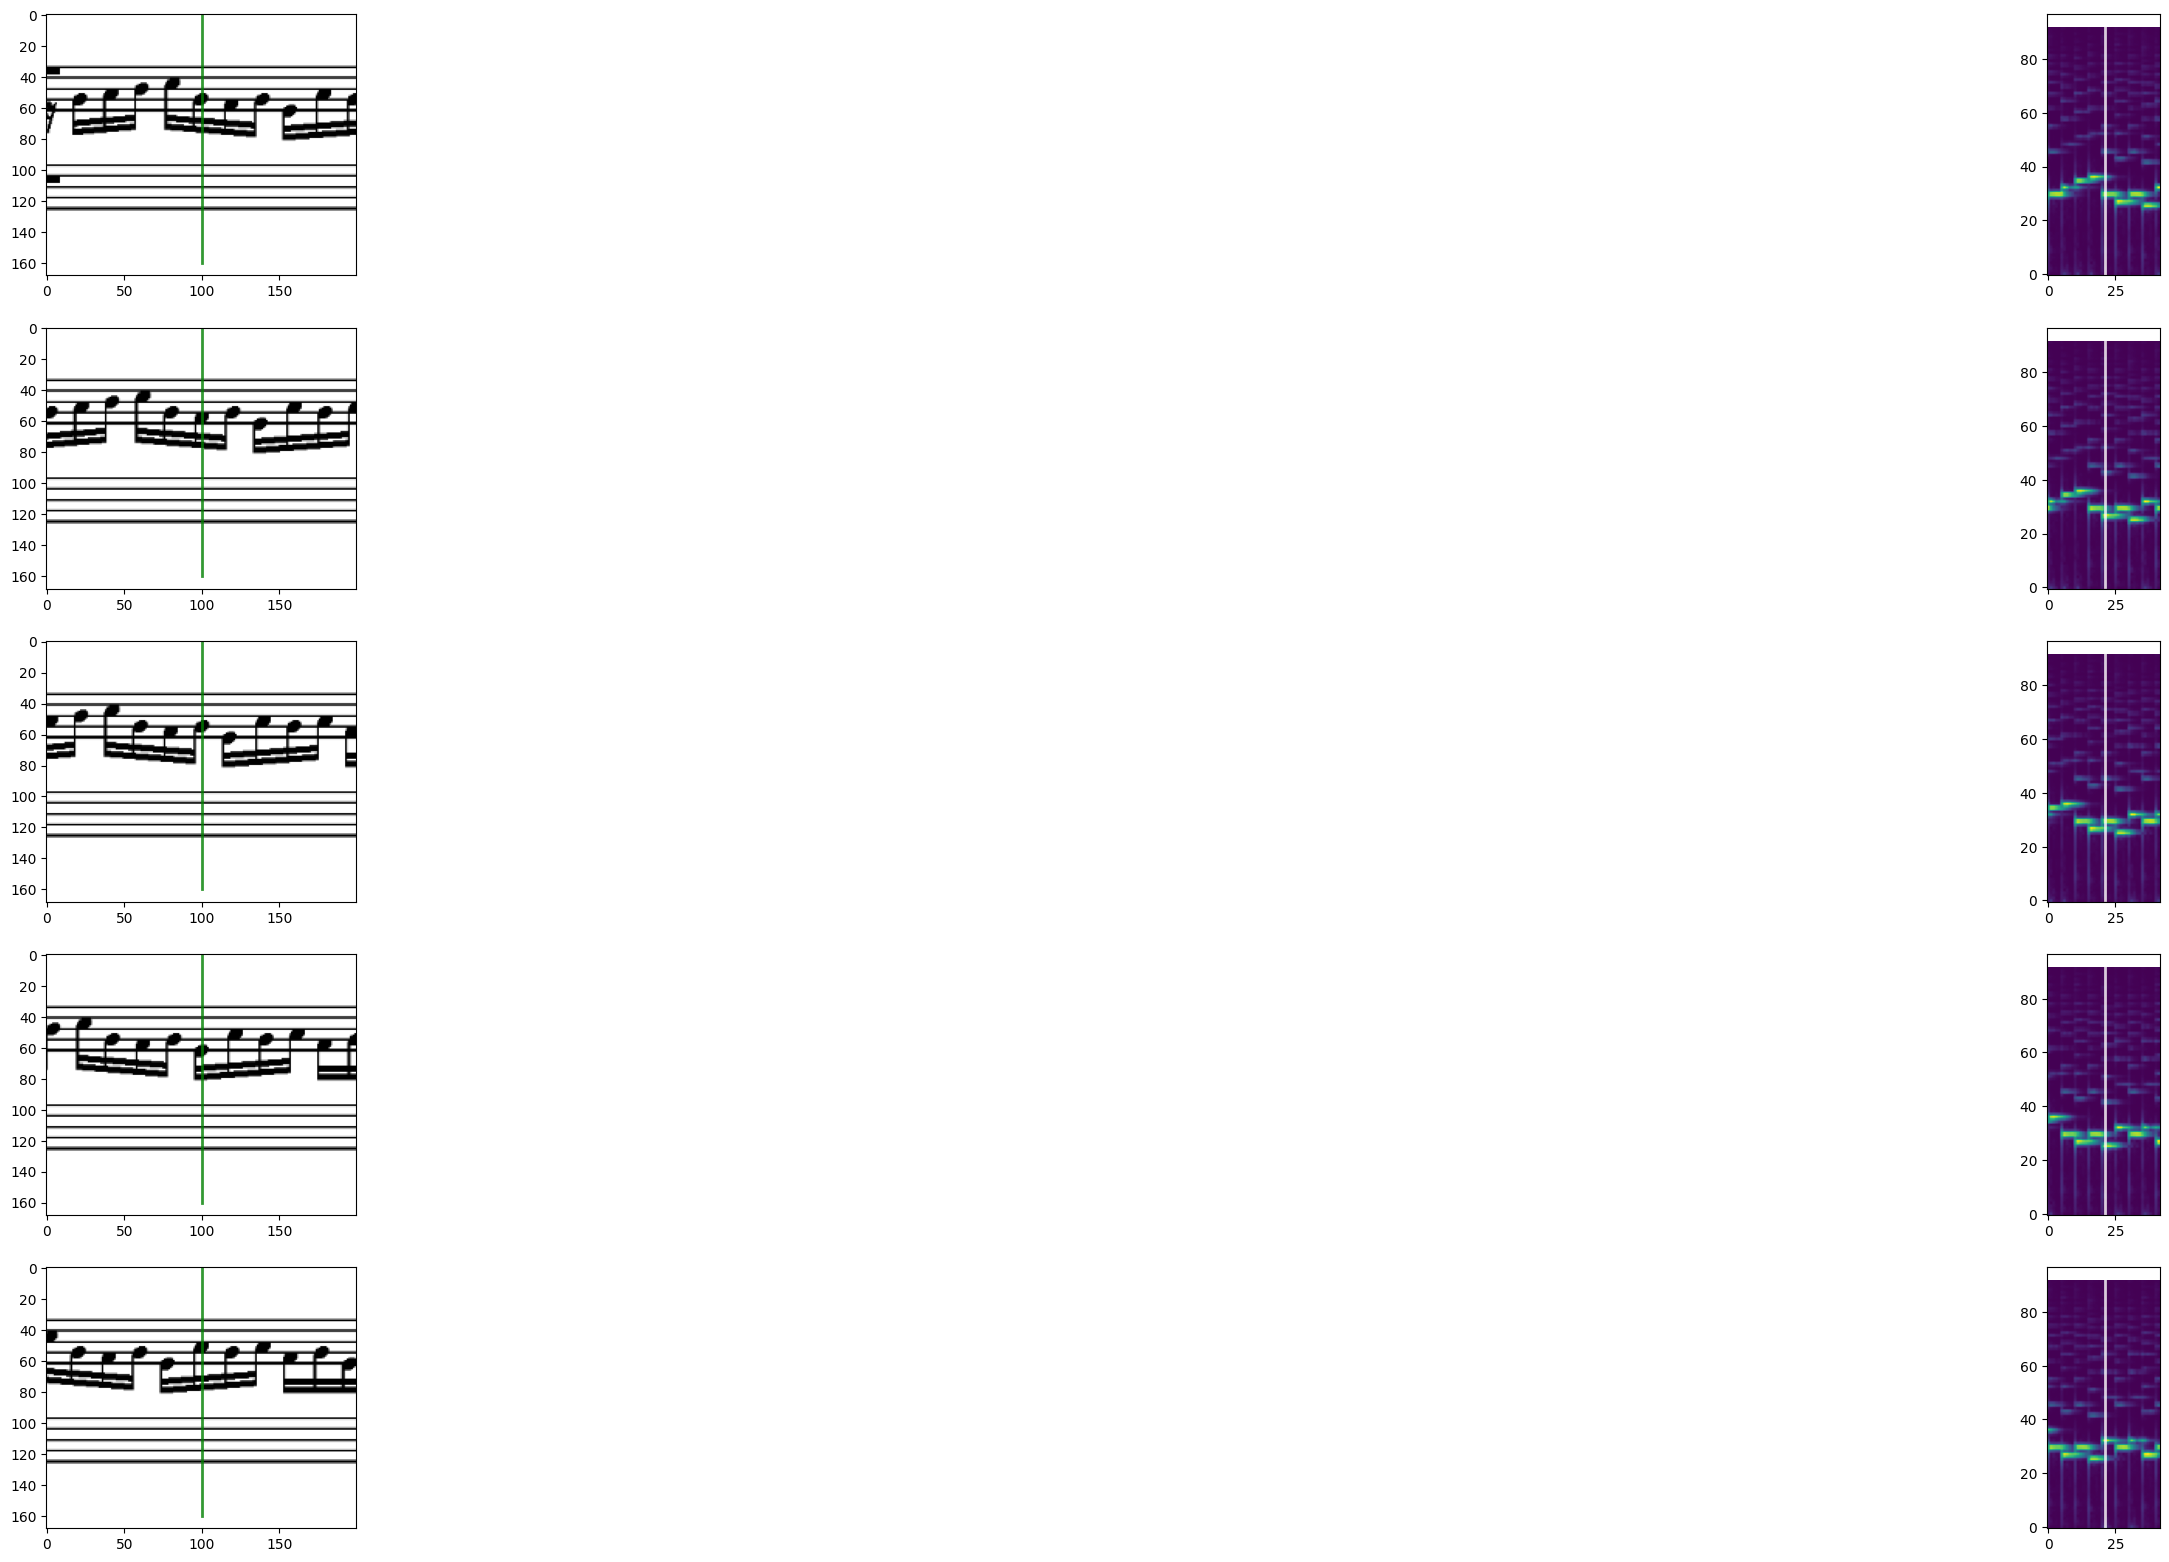

In [57]:

# Enable autoreload
%load_ext autoreload

# Set autoreload mode to reload all modules every time before executing code
%autoreload 2
plotting = 1
plt.figure('Spectrogram slices & Sheet snippets', figsize=(45,40))

for key in range(5):


    # get batch
    if key.__class__ == int:
        key = slice(key, key + 1)
    batch_entities = piece_pool.train_entities[key]

    # collect train entities
    sheet_batch = np.zeros((len(batch_entities), 1, piece_pool.sheet_dim[0], piece_pool.sheet_context), dtype=np.float32)
    spec_batch = np.zeros((len(batch_entities), 1, piece_pool.spec_dim[0], piece_pool.spec_context), dtype=np.float32)
    # for i_entity, (i_sheet, i_spec, i_onset) in enumerate(batch_entities):
    for i_entity, (i_sheet, i_spec, i_onset) in enumerate(batch_entities):
        # print(plotting, i_entity, (i_sheet, i_spec, i_onset), (piece_pool.o2c_maps[i_sheet][i_spec][i_onset]))
        # get sliding window train item
        snippet = piece_pool.prepare_train_image(i_sheet, i_spec, i_onset)

        # get spectrogram excerpt (target note in center)
        excerpt = piece_pool.prepare_train_audio(i_sheet, i_spec, i_onset)

        # # collect batch data
        # sheet_batch[i_entity, 0, :, :] = snippet
        # spec_batch[i_entity, 0, :, :] = excerpt

        

        # plt.clf()
        plt.subplot(10, 2, plotting)
        plt.imshow(snippet, cmap="gray")
        plt.plot([snippet.shape[1]//2, snippet.shape[1]//2], [0, snippet.shape[0]], 'g-', alpha=.8, linewidth=2)
        plotting+=1


        plt.subplot(10, 2, plotting)
        plt.imshow(excerpt, cmap="viridis", origin="lower")
        plt.plot([excerpt.shape[1]//2, excerpt.shape[1]//2], [0, excerpt.shape[0]], 'w-', alpha=.8, linewidth=2)


        plotting+=1
    # print(snippet.shape, excerpt.shape)
    # return [sheet_batch, spec_batch]
plt.show()

I ONSET: 0 with 85 >> (0, 800)
    20, 180 -> 0, 200
I ONSET: 1 with 105 >> (0, 800)
    20, 180 -> 5, 205
I ONSET: 2 with 125 >> (0, 800)
    20, 180 -> 25, 225
I ONSET: 3 with 144 >> (0, 800)
    20, 180 -> 44, 244
I ONSET: 4 with 163 >> (0, 800)
    20, 180 -> 63, 263


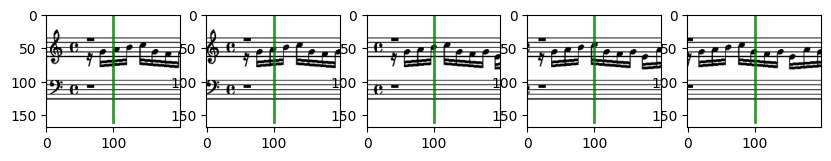

In [58]:
plt.figure('Spectrogram slices & Sheet snippets', figsize=(10,40))

for i in range(5):
    snippet = piece_pool.prepare_train_image(0, 0, i)
    plt.subplot(1, 5, i+1)
    plt.imshow(snippet, cmap="gray")
    plt.plot([snippet.shape[1]//2, snippet.shape[1]//2], [0, snippet.shape[0]], 'g-', alpha=.8, linewidth=2)

# 🔮 Testing out different stuff

In [66]:
from audio_sheet_retrieval.utils.data_pools import stack_images, unwrap_sheet_image, align_score_to_performance, onset_to_coordinates
piece_name = 'BachJS__BWV790__bwv790'
piece = Piece(root=DATA_ROOT_MSMD, name=piece_name)

score = piece.load_score(piece.available_scores[0])

# get mungos
mungos = score.load_mungos()
mdict = {m.objid: m for m in mungos}
mungos_per_page = score.load_mungos(by_page=True)

# load images
images = score.load_images()

# stack sheet images
image, page_mungos, mdict = stack_images(images, mungos_per_page, mdict)

# get only system mungos for unwrapping
system_mungos = [c for c in page_mungos if c.clsname == 'staff']
system_mungos = sorted(system_mungos, key=lambda m: m.top)

# unwrap sheet images
un_wrapped_image, un_wrapped_coords = unwrap_sheet_image(image, system_mungos, mdict)

# load performances
spectrograms = []
midi_matrices = []
onset_to_coord_maps = []

for performance_key in piece.available_performances:
    print(performance_key)
    # check if performance matches augmentation pattern
    tempo, synth = performance_key.split("tempo-")[1].split("_", 1)
    tempo = float(tempo) / 1000

    # if synth not in aug_config["synths"]\
    #         or tempo < aug_config["tempo_range"][0]\
    #         or tempo > aug_config["tempo_range"][1]:
    #     continue

    # load current performance
    performance = piece.load_performance(performance_key, require_audio=False)

    # running the alignment procedure
    alignment = align_score_to_performance(score, performance)

    # note events
    note_events = performance.load_note_events()

    # load spectrogram
    spec = performance.load_spectrogram()
    spectrograms.append(spec)

    # compute onset to coordinate mapping
    onset_to_coord = onset_to_coordinates(alignment, un_wrapped_coords, note_events)
    onset_to_coord_maps.append(onset_to_coord)
    print(f'    Current: {len(spec)} | {len(onset_to_coord)}')
    print(f'    Shape {un_wrapped_image.shape} | {len(spectrograms)} | {len(onset_to_coord_maps)}')
    
    # return un_wrapped_image, spectrograms, onset_to_coord_maps


BachJS__BWV790__bwv790_tempo-1000_ElectricPiano
    Current: 92 | 340
    Shape (200, 8267) | 1 | 1
BachJS__BWV790__bwv790_tempo-1000_YamahaGrandPiano
    Current: 92 | 340
    Shape (200, 8267) | 2 | 2
BachJS__BWV790__bwv790_tempo-1000_acoustic_piano_imis_1
    Current: 92 | 340
    Shape (200, 8267) | 3 | 3
BachJS__BWV790__bwv790_tempo-1000_grand-piano-YDP-20160804
    Current: 92 | 340
    Shape (200, 8267) | 4 | 4
BachJS__BWV790__bwv790_tempo-1050_acoustic_piano_imis_1
    Current: 92 | 340
    Shape (200, 8267) | 5 | 5
BachJS__BWV790__bwv790_tempo-1100_acoustic_piano_imis_1
    Current: 92 | 340
    Shape (200, 8267) | 6 | 6
BachJS__BWV790__bwv790_tempo-1250_grand-piano-YDP-20160804
    Current: 92 | 340
    Shape (200, 8267) | 7 | 7
BachJS__BWV790__bwv790_tempo-1500_grand-piano-YDP-20160804
    Current: 92 | 340
    Shape (200, 8267) | 8 | 8
BachJS__BWV790__bwv790_tempo-1750_grand-piano-YDP-20160804
    Current: 92 | 340
    Shape (200, 8267) | 9 | 9
BachJS__BWV790__bwv790_tempo-

In [65]:
for o in onset_to_coord_maps:
    print(f'{len(o)}/{len(onset_to_coord_maps)}')

340/15
340/15
340/15
340/15
340/15
340/15
340/15
340/15
340/15
340/15
340/15
340/15
340/15
340/15
340/15
